# **Example of usefull application for shadow removal**
The result of implemented shadow removal algorithm was not perfect, but still could be usefull for some applications, for example navigable area in eucalyptus platation based on difference of color from forest/plant and the road.

This scenario's difficulty was actually experienced from me in a test I tried to implement to learn computer vision by myself on last year.

In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import matplotlib as mpl

With this in mind, this notebook aims to compare the Hue limiarization, using 'H' channel from HSV colorspace, on original scene with shadows and the unshadowed result obtained.

First step is to read both images, the original and the unshadowed result.

Text(0.5, 1.0, 'unshadowed scene')

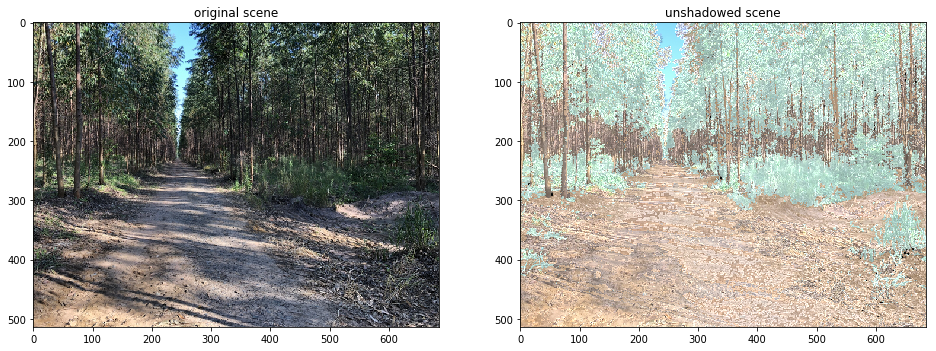

In [2]:
""" Readding the original and unshadowed scenarios """

shadowed = imageio.imread("../images/shadowE.jpg")
unshadowed = imageio.imread("4thTry.png")

plt.figure(figsize=(16,8))
plt.subplot(121);plt.imshow(shadowed);plt.title("original scene")
plt.subplot(122);plt.imshow(unshadowed);plt.title("unshadowed scene")

Next step is to convert both images colorspace from RGB to HSV and compare each channel from each images.
Observe the unshadowed image has a much "cleaner" road, since the shadow's crominance distortion was fixed with shadow removal algorithm.

For curiosity, observe that the value channel 'V' also shows that the luminance distortion from shadows was fixed.

Text(0.5, 1.0, 'V unshadow')

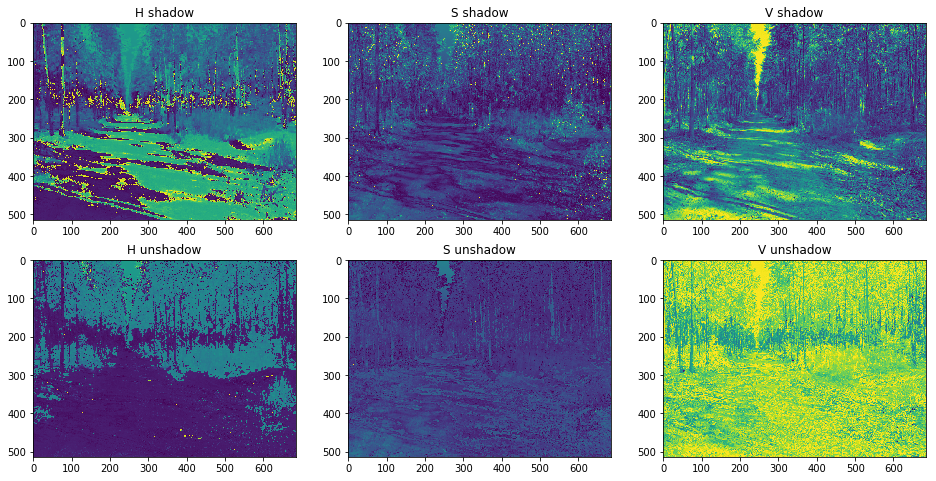

In [3]:
""" Converting colorspace from RGB to HSV """

hsv_shadow = mpl.colors.rgb_to_hsv(shadowed)
hsv_unshadow = mpl.colors.rgb_to_hsv(unshadowed)

plt.figure(figsize=(16,8))
plt.subplot(231);plt.imshow(hsv_shadow[:,:,0]);plt.title("H shadow")
plt.subplot(232);plt.imshow(hsv_shadow[:,:,1]);plt.title("S shadow")
plt.subplot(233);plt.imshow(hsv_shadow[:,:,2]);plt.title("V shadow")
plt.subplot(234);plt.imshow(hsv_unshadow[:,:,0]);plt.title("H unshadow")
plt.subplot(235);plt.imshow(hsv_unshadow[:,:,1]);plt.title("S unshadow")
plt.subplot(236);plt.imshow(hsv_unshadow[:,:,2]);plt.title("V unshadow")

By limiarizing the images based on their Hue value it is obtained the following binary images, an as expected, from the unshadowed image the result was better, considering the road detection.

Text(0.5, 1.0, 'binarized Hue unshadowed image')

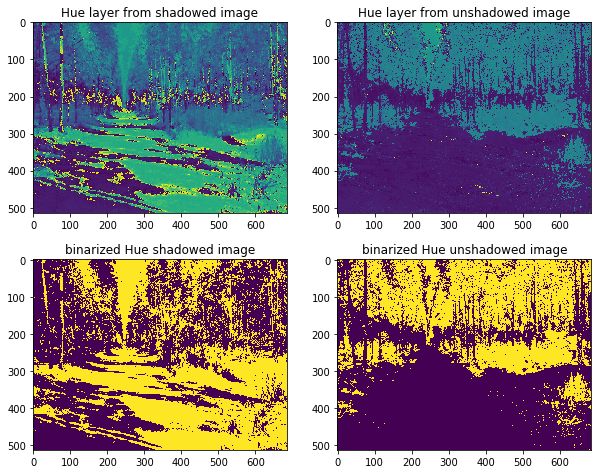

In [46]:
""" Limiarization of images based on Hue thresholding (color) """

shadow_bin = np.zeros(shadowed[:,:,0].shape, dtype=np.uint8)
unshadow_bin = np.zeros(unshadowed[:,:,0].shape, dtype=np.uint8)

shadow_bin[np.where(hsv_shadow[:,:,0]>0.35)] = 1
unshadow_bin[np.where(hsv_unshadow[:,:,0]>0.35)] = 1
unshadow_bin[np.where(hsv_unshadow[:,:,0]>0.55)] = 0

plt.figure(figsize=(10,8))
plt.subplot(221);plt.imshow(hsv_shadow[:,:,0]);plt.title("Hue layer from shadowed image")
plt.subplot(222);plt.imshow(hsv_unshadow[:,:,0]);plt.title("Hue layer from unshadowed image")
plt.subplot(223);plt.imshow(shadow_bin);plt.title("binarized Hue shadowed image")
plt.subplot(224);plt.imshow(unshadow_bin);plt.title("binarized Hue unshadowed image")
# plt.savefig("shadowXunshadow_limiarization")

To finalize the navigable area detection, morphological operation functions were implemented (erosion and dilation), so the small noise dots could be removed andd the navigable region closed.

In [58]:
""" Morphological filters """

# Erosion filter
def erode(img, kernel=np.array([[0,1,0],[1,1,1],[0,1,0]])):
    kernel = 1 - kernel
    k = kernel.shape[0]
    result = np.copy(img)
    
    N,M = img.shape
    for x in range(k//2,N-(k//2)):
        for y in range(k//2,M-(k//2)):
            if(img[x,y] == 0):
                for kx in range((-k//2)+1, (k//2)+1):
                    for ky in range((-k//2)+1, (k//2)+1):
                        if(kernel[k//2+kx,k//2+ky] == 0):
                            result[x+kx, y+ky] = img[x+kx, y+ky] * kernel[k//2+kx,k//2+ky]
    return result

# Dilation filter
def dilate(img, kernel=np.array([[0,1,0],[1,1,1],[0,1,0]])):
    k = kernel.shape[0]
    result = np.copy(img)
    
    N,M = img.shape
    for x in range(k//2,N-k//2):
        for y in range(k//2,M-k//2):
            if(img[x,y] == 1):
                for kx in range((-k//2)+1, (k//2)+1):
                    for ky in range((-k//2)+1, (k//2)+1):
                        if(kernel[k//2+kx,k//2+ky] == 1):
                            result[x+kx, y+ky] = result[x+kx, y+ky] or kernel[k//2+kx,k//2+ky]
    return result


diamond_k = np.array([[0,0,0,0,1,0,0,0,0],
                      [0,0,0,1,1,1,0,0,0],
                      [0,0,1,1,1,1,1,0,0],
                      [0,1,1,1,1,1,1,1,0],
                      [1,1,1,1,1,1,1,1,1],
                      [0,1,1,1,1,1,1,1,0],
                      [0,0,1,1,1,1,1,0,0],
                      [0,0,0,1,1,1,0,0,0],
                      [0,0,0,0,1,0,0,0,0]])

unshadow_bin_eroded = erode(unshadow_bin)
unshadow_bin_dilated = np.copy(unshadow_bin_eroded)

for n in range(8):
    unshadow_bin_dilated = dilate(unshadow_bin_dilated, diamond_k)

The final result of road detection can be seen below.

From this point was not developed, but an inverse perspective transformation could be done for the navigable area detection, in this way even small curves can be perceived.

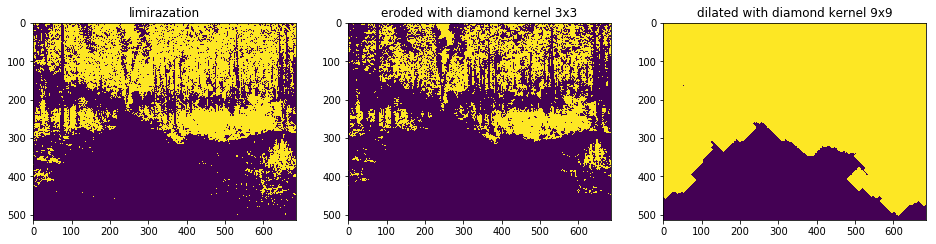

In [66]:
plt.figure(figsize=(16,5))
plt.subplot(131);plt.imshow(unshadow_bin);plt.title("limirazation")
plt.subplot(132);plt.imshow(unshadow_bin_eroded);plt.title("eroded with diamond kernel 3x3")
plt.subplot(133);plt.imshow(unshadow_bin_dilated);plt.title("dilated with diamond kernel 9x9")
# plt.savefig("navigable_area_detection")